<a href="https://colab.research.google.com/github/Joebasshd/irembo-voice-ai/blob/main/EDA_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install huggingface_hub[hf_xet]

In [2]:
! pip install transformers datasets peft accelerate evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import evaluate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, PeftConfig


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/irembo-voice-ai/data/augmented_train_set.csv')
val_df = pd.read_csv('/content/drive/MyDrive/irembo-voice-ai/data/voiceai_intent_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/irembo-voice-ai/data/voiceai_intent_test.csv')

In [6]:
print(train_df.shape)
train_df.head()

(902, 11)


,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
0,utt_00159,2025-11-07T15:32:00,whatsapp_voice_note,feature_phone,Western,en,What are the requirements for ID replacement?,0.902,9,requirements_information,train
1,utt_00501,2025-11-12T10:41:00,voice_call,android,Kigali,en,Am I eligible to apply for ESIA?,0.644,7,service_eligibility,train
2,utt_00397,2025-11-28T17:58:00,ivr,web,Eastern,mixed,Help me reset password yanjye.,0.964,9,reset_password_login_help,train
3,utt_00156,2025-11-25T19:52:00,voice_call,web,Southern,en,I submitted my aplikasiyo but I can't see the ...,0.911,2,check_application_status,train
4,utt_00322,2025-11-24T00:46:00,voice_call,feature_phone,Eastern,en,I want to start a new application for birth ce...,0.810,10,start_new_application,train


In [7]:
print(val_df.shape)
val_df.head()

(70, 11)


,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
0,utt_00037,2025-10-08T19:45:00,voice_call,ios,Western,en,How do I begin an application for driving lice...,0.972,2,payment_help,val
1,utt_00184,2025-10-26T01:34:00,voice_call,android,Kigali,rw,Uburyo bwo kwishyura tax clearance ni ubuhe?,0.807,5,payment_help,val
2,utt_00130,2025-12-08T16:41:00,mobile_app_voice,android,Northern,mixed,Nashaka gufata appointment ya ESIA i Muhanga.,0.695,5,appointment_booking,val
3,utt_00551,2025-09-28T20:32:00,mobile_app_voice,web,Northern,mixed,Nishyuye but ntabwo byemejwe.,0.885,5,payment_help,val
4,utt_00538,2025-10-17T20:13:00,whatsapp_voice_note,ios,Kigali,rw,Ndashaka booking yigihe kuri gusimbuza indanga...,0.864,6,appointment_booking,val


In [8]:
print(test_df.shape)
test_df.head()

(69, 11)


,utterance_id,timestamp,channel,device_type,region,language,utterance_text,asr_confidence,duration_seconds,intent,split
0,utt_00547,2025-12-24T04:35:00,whatsapp_voice_note,feature_phone,Northern,rw,"Nishyuye ariko ntibyemejwe, nafasha?",0.986,3,payment_help,test
1,utt_00099,2025-11-14T18:32:00,ivr,feature_phone,Southern,rw,Amabwiriza yo gusaba driving license ni ayahe?,0.853,4,requirements_information,test
2,utt_00503,2025-11-06T20:03:00,voice_call,web,Southern,rw,Ese gusimbuza indangamuntu iba isabwa n’abantu...,0.949,8,service_eligibility,test
3,utt_00694,2025-11-07T21:12:00,ivr,ios,Kigali,rw,Nkeneye ibisabwa byo gukora visa yo kuza.,0.815,4,requirements_information,test
4,utt_00063,2025-11-03T15:02:00,whatsapp_voice_note,android,Kigali,rw,Nkeneye ibisabwa byo gukora passport.,0.861,7,requirements_information,test


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   utterance_id      902 non-null    object 
 1   timestamp         902 non-null    object 
 2   channel           902 non-null    object 
 3   device_type       902 non-null    object 
 4   region            902 non-null    object 
 5   language          902 non-null    object 
 6   utterance_text    902 non-null    object 
 7   asr_confidence    902 non-null    float64
 8   duration_seconds  902 non-null    int64  
 9   intent            902 non-null    object 
 10  split             902 non-null    object 
dtypes: float64(1), int64(1), object(9)
memory usage: 77.6+ KB


### **Intent Distribution Analysis**

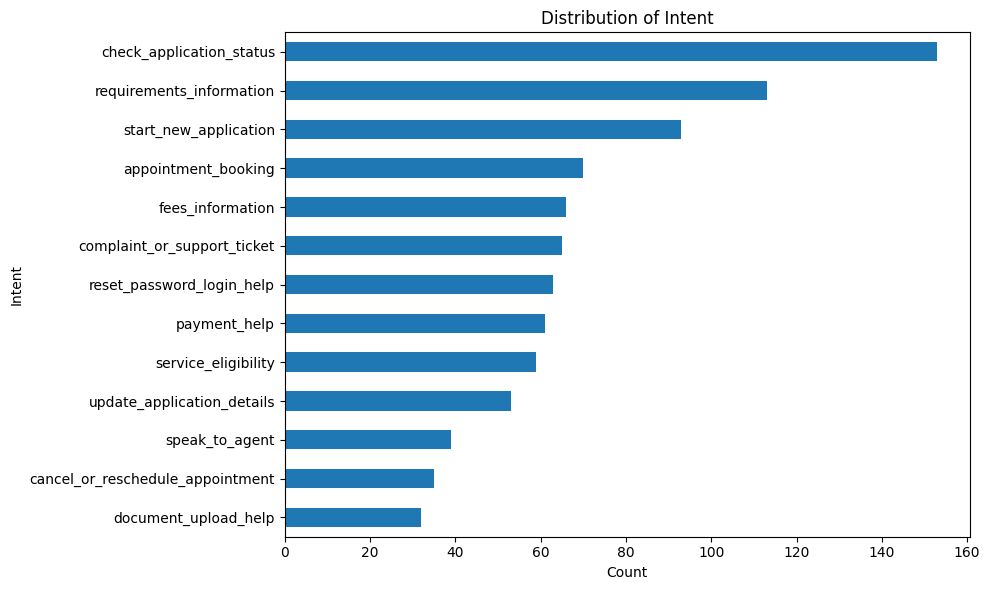

In [15]:
# Count occurrences of each intent
intent_counts = train_df['intent'].value_counts().sort_values(ascending=True)

# Plot bar chart
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='barh')
plt.title('Distribution of Intent')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.tight_layout()
plt.show()

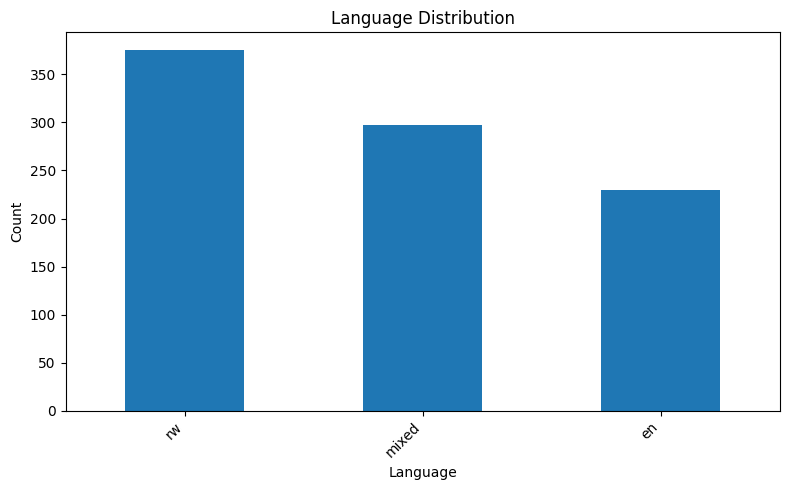

In [16]:
# Bar chart of language distribution
plt.figure(figsize=(8, 5))
train_df['language'].value_counts().plot(kind='bar')
plt.title('Language Distribution')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

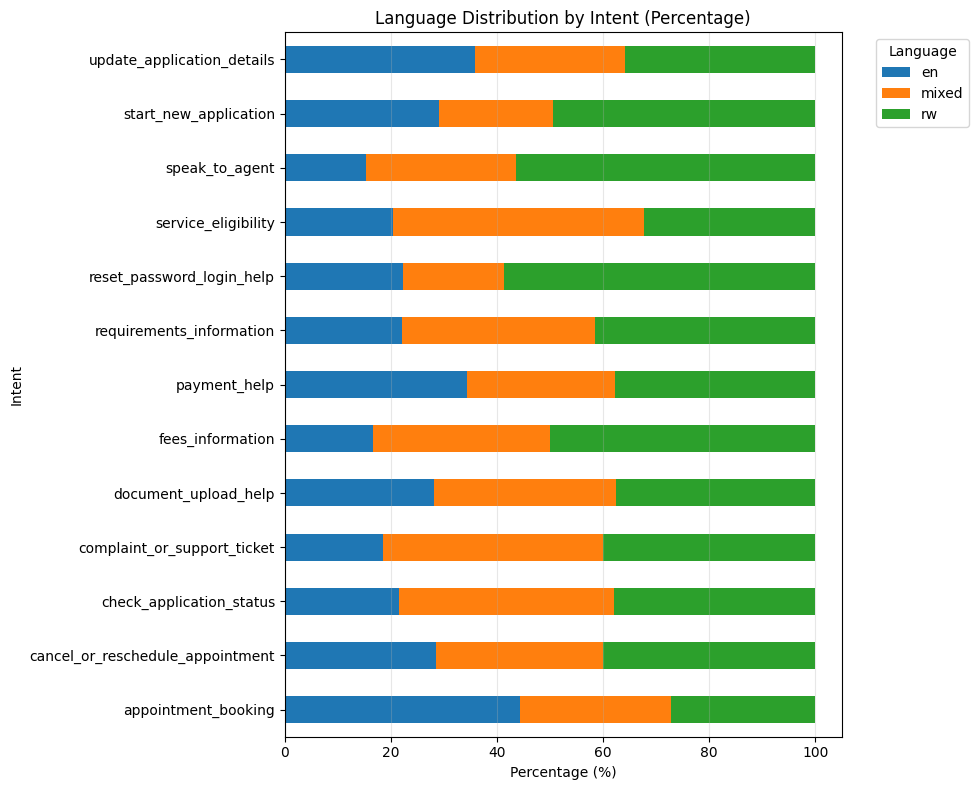

In [18]:
# Create crosstab of intent vs language (counts)
intent_language_counts = train_df.groupby(['intent', 'language']).size().unstack(fill_value=0)

# Convert to percentages (each row sums to 100%)
intent_language_pct = intent_language_counts.div(intent_language_counts.sum(axis=1), axis=0) * 100

# Plot horizontal stacked bar chart
plt.figure(figsize=(10, 8))
intent_language_pct.plot(kind='barh', stacked=True, figsize=(10, 8))

plt.title('Language Distribution by Intent (Percentage)')
plt.xlabel('Percentage (%)')
plt.ylabel('Intent')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### **Model Building**

In [19]:
full_train_df = pd.concat([train_df, val_df], ignore_index=True)

le = LabelEncoder()
le.fit(full_train_df['intent'])

full_train_df['label'] = le.transform(full_train_df['intent'])
test_df['label'] = le.transform(test_df['intent'])

# Mappings for the model config
id2label = {i: label for i, label in enumerate(le.classes_)}
label2id = {label: i for i, label in enumerate(le.classes_)}

print(f"Total Training Samples: {len(full_train_df)}")
print(f"Test Set Samples (Holdout): {len(test_df)}")

Total Training Samples: 972
Test Set Samples (Holdout): 69


In [20]:
# Tokenizer Setup
model_id = "davlan/afro-xlmr-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
    return tokenizer(examples["utterance_text"], truncation=True, padding=True, max_length=128)

def compute_metrics(eval_pred):
    metric = evaluate.load("f1")
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [21]:
# --- CONFIGURATION ---
outer_splits = 5
inner_splits = 3
param_grid = [
    {'learning_rate': 1e-4, 'r': 8},
    {'learning_rate': 2e-4, 'r': 16},
]

# --- PREPARATION ---
skf_outer = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
outer_results = []
best_params_history = []

print(f"\n--- Starting Nested Cross-Validation (Outer={outer_splits}, Inner={inner_splits}) ---")

# --- OUTER LOOP (Evaluation) ---
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(skf_outer.split(full_train_df, full_train_df['label'])):
    print(f"\n[Outer Fold {outer_fold + 1}/{outer_splits}] Processing...")

    # Create the datasets for this Outer Fold
    outer_train_df = full_train_df.iloc[outer_train_idx].reset_index(drop=True)
    outer_test_df = full_train_df.iloc[outer_test_idx].reset_index(drop=True)

    # --- INNER LOOP (Hyperparameter Tuning) ---
    best_score = -1
    best_params = param_grid[0] # Default

    print(f"  > Starting Inner Loop Grid Search...")

    for params in param_grid:
        inner_scores = []
        skf_inner = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(skf_inner.split(outer_train_df, outer_train_df['label'])):

            # Prepare Inner Data
            inner_train_df = outer_train_df.iloc[inner_train_idx]
            inner_val_df = outer_train_df.iloc[inner_val_idx]

            # Dataset Conversion & Cleaning
            inner_ds = DatasetDict({
                "train": Dataset.from_pandas(inner_train_df),
                "validation": Dataset.from_pandas(inner_val_df)
            })

            keep_columns = ["input_ids", "attention_mask", "label"]
            tokenized_inner = inner_ds.map(preprocess_function, batched=True)
            cols_to_remove = [col for col in tokenized_inner["train"].column_names if col not in keep_columns]
            tokenized_inner = tokenized_inner.remove_columns(cols_to_remove)
            if "__index_level_0__" in tokenized_inner["train"].column_names:
                tokenized_inner = tokenized_inner.remove_columns(["__index_level_0__"])

            # Model Init (Fresh for every inner fold)
            model = AutoModelForSequenceClassification.from_pretrained(
                model_id, num_labels=len(le.classes_), id2label=id2label, label2id=label2id
            )
            peft_config = LoraConfig(
                task_type=TaskType.SEQ_CLS, inference_mode=False,
                r=params['r'], lora_alpha=params['r']*2, lora_dropout=0.1, target_modules=["query", "value"]
            )
            model = get_peft_model(model, peft_config)

            # Short Training for Tuning
            training_args = TrainingArguments(
                output_dir=f"./results_inner_temp",
                learning_rate=params['learning_rate'],
                per_device_train_batch_size=16,
                per_device_eval_batch_size=16,
                num_train_epochs=3,
                eval_strategy="epoch",
                save_strategy="no",
                report_to="none",
                logging_steps=500
            )

            trainer = Trainer(
                model=model, args=training_args,
                train_dataset=tokenized_inner["train"],
                eval_dataset=tokenized_inner["validation"],
                processing_class=tokenizer, data_collator=data_collator,
                compute_metrics=compute_metrics,
            )
            trainer.train()
            metrics = trainer.evaluate()
            inner_scores.append(metrics['eval_f1'])

        # Check if this param combo is the winner
        avg_inner_score = np.mean(inner_scores)
        print(f"    Params {params} -> Avg F1: {avg_inner_score:.4f}")

        if avg_inner_score > best_score:
            best_score = avg_inner_score
            best_params = params

    print(f"  > Best Params Found for Outer Fold {outer_fold+1}: {best_params}")
    best_params_history.append(best_params)

    # --- FINAL TRAINING FOR OUTER FOLD (Using Best Params) ---
    print(f"  > Refitting on full Outer Train set...")

    # Dataset Conversion
    outer_ds = DatasetDict({
        "train": Dataset.from_pandas(outer_train_df),
        "validation": Dataset.from_pandas(outer_test_df) # Evaluate on the unseen Outer Test
    })
    tokenized_outer = outer_ds.map(preprocess_function, batched=True)
    tokenized_outer = tokenized_outer.remove_columns(["utterance_text", "intent", "language", "asr_confidence", "utterance_id"])
    if "__index_level_0__" in tokenized_outer["train"].column_names:
        tokenized_outer = tokenized_outer.remove_columns(["__index_level_0__"])

    # Model Init (Fresh one last time)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_id, num_labels=len(le.classes_), id2label=id2label, label2id=label2id
    )
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS, inference_mode=False,
        r=best_params['r'], lora_alpha=best_params['r']*2, lora_dropout=0.1, target_modules=["query", "value"]
    )
    model = get_peft_model(model, peft_config)

    # Full Training
    training_args = TrainingArguments(
        output_dir=f"./results_outer_fold_{outer_fold}",
        learning_rate=best_params['learning_rate'],
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5, # Full epochs
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        report_to="none"
    )

    trainer = Trainer(
        model=model, args=training_args,
        train_dataset=tokenized_outer["train"],
        eval_dataset=tokenized_outer["validation"],
        processing_class=tokenizer, data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # Final Eval on Outer Test
    final_metrics = trainer.evaluate()
    print(f"  > Outer Fold {outer_fold + 1} Test F1: {final_metrics['eval_f1']:.4f}")
    outer_results.append(final_metrics['eval_f1'])


--- Starting Nested Cross-Validation (Outer=5, Inner=3) ---

[Outer Fold 1/5] Processing...
  > Starting Inner Loop Grid Search...


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.396837,0.077589
2,No log,2.294953,0.080141
3,No log,2.235966,0.115394


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.408518,0.044057
2,No log,2.325590,0.066256
3,No log,2.286761,0.072855


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.400889,0.077225
2,No log,2.290665,0.106273
3,No log,2.249705,0.118207


    Params {'learning_rate': 0.0001, 'r': 8} -> Avg F1: 0.1022


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.269856,0.083320
2,No log,1.944957,0.244883
3,No log,1.822023,0.308403


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.289210,0.095171
2,No log,1.940454,0.228580
3,No log,1.839374,0.253176


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.264555,0.098788
2,No log,1.957231,0.221829
3,No log,1.873397,0.298333


    Params {'learning_rate': 0.0002, 'r': 16} -> Avg F1: 0.2866
  > Best Params Found for Outer Fold 1: {'learning_rate': 0.0002, 'r': 16}
  > Refitting on full Outer Train set...


Map:   0%|          | 0/777 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.082803,0.182330
2,No log,1.370589,0.524927
3,No log,0.914211,0.732028
4,No log,0.685573,0.829057
5,No log,0.617061,0.840377


  > Outer Fold 1 Test F1: 0.8404

[Outer Fold 2/5] Processing...
  > Starting Inner Loop Grid Search...


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.393226,0.065984
2,No log,2.255966,0.068335
3,No log,2.197242,0.094812


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.408549,0.074501
2,No log,2.312212,0.065620
3,No log,2.269093,0.075929


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.408655,0.064024
2,No log,2.323585,0.063513
3,No log,2.286484,0.076227


    Params {'learning_rate': 0.0001, 'r': 8} -> Avg F1: 0.0823


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.287944,0.060429
2,No log,1.984485,0.205146
3,No log,1.889445,0.240425


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.280046,0.098199
2,No log,2.039912,0.193540
3,No log,1.947487,0.252926


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.317144,0.071157
2,No log,1.992940,0.230496
3,No log,1.907055,0.290508


    Params {'learning_rate': 0.0002, 'r': 16} -> Avg F1: 0.2613
  > Best Params Found for Outer Fold 2: {'learning_rate': 0.0002, 'r': 16}
  > Refitting on full Outer Train set...


Map:   0%|          | 0/777 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.021098,0.204458
2,No log,1.422272,0.515076
3,No log,0.983351,0.655811
4,No log,0.743371,0.760047
5,No log,0.691874,0.794953


  > Outer Fold 2 Test F1: 0.7950

[Outer Fold 3/5] Processing...
  > Starting Inner Loop Grid Search...


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.382639,0.075948
2,No log,2.271233,0.117048
3,No log,2.226201,0.128178


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.402903,0.046240
2,No log,2.293767,0.074207
3,No log,2.257048,0.085495


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.418478,0.065308
2,No log,2.327071,0.083133
3,No log,2.283967,0.101145


    Params {'learning_rate': 0.0001, 'r': 8} -> Avg F1: 0.1049


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.285029,0.097905
2,No log,2.022458,0.239157
3,No log,1.954955,0.295779


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.251917,0.101371
2,No log,1.933163,0.224637
3,No log,1.850942,0.285034


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.310580,0.066920
2,No log,1.941132,0.186769
3,No log,1.820342,0.229145


    Params {'learning_rate': 0.0002, 'r': 16} -> Avg F1: 0.2700
  > Best Params Found for Outer Fold 3: {'learning_rate': 0.0002, 'r': 16}
  > Refitting on full Outer Train set...


Map:   0%|          | 0/778 [00:00<?, ? examples/s]

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.961747,0.237212
2,No log,1.340505,0.519056
3,No log,0.875454,0.789317
4,No log,0.671981,0.859902
5,No log,0.636080,0.864641


  > Outer Fold 3 Test F1: 0.8646

[Outer Fold 4/5] Processing...
  > Starting Inner Loop Grid Search...


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.395409,0.061884
2,No log,2.275637,0.106367
3,No log,2.230277,0.108578


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.419845,0.052350
2,No log,2.321428,0.055748
3,No log,2.279967,0.070408


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.424179,0.066510
2,No log,2.327182,0.088435
3,No log,2.280650,0.085509


    Params {'learning_rate': 0.0001, 'r': 8} -> Avg F1: 0.0882


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.258221,0.075358
2,No log,1.977970,0.207006
3,No log,1.880418,0.239328


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.282805,0.058424
2,No log,2.008845,0.259498
3,No log,1.898667,0.278864


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.309562,0.090192
2,No log,1.990909,0.121149
3,No log,1.884783,0.162823


    Params {'learning_rate': 0.0002, 'r': 16} -> Avg F1: 0.2270
  > Best Params Found for Outer Fold 4: {'learning_rate': 0.0002, 'r': 16}
  > Refitting on full Outer Train set...


Map:   0%|          | 0/778 [00:00<?, ? examples/s]

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.962963,0.209025
2,No log,1.454752,0.457935
3,No log,1.004552,0.710958
4,No log,0.844866,0.743486
5,No log,0.787521,0.772538


  > Outer Fold 4 Test F1: 0.7725

[Outer Fold 5/5] Processing...
  > Starting Inner Loop Grid Search...


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.393957,0.051647
2,No log,2.258208,0.103849
3,No log,2.197595,0.146330


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.417295,0.042100
2,No log,2.321947,0.070590
3,No log,2.271466,0.079743


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.397547,0.046538
2,No log,2.306893,0.079000
3,No log,2.259832,0.099300


    Params {'learning_rate': 0.0001, 'r': 8} -> Avg F1: 0.1085


Map:   0%|          | 0/518 [00:00<?, ? examples/s]

Map:   0%|          | 0/260 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.270062,0.133700
2,No log,1.970509,0.230005
3,No log,1.865148,0.296088


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.321420,0.104832
2,No log,1.960022,0.206860
3,No log,1.854816,0.235559


Map:   0%|          | 0/519 [00:00<?, ? examples/s]

Map:   0%|          | 0/259 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,2.239037,0.106531
2,No log,1.937205,0.240424
3,No log,1.840119,0.273681


    Params {'learning_rate': 0.0002, 'r': 16} -> Avg F1: 0.2684
  > Best Params Found for Outer Fold 5: {'learning_rate': 0.0002, 'r': 16}
  > Refitting on full Outer Train set...


Map:   0%|          | 0/778 [00:00<?, ? examples/s]

Map:   0%|          | 0/194 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,1.892361,0.358300
2,No log,1.239861,0.522962
3,No log,0.843091,0.734279
4,No log,0.683252,0.765576
5,No log,0.633551,0.823627


  > Outer Fold 5 Test F1: 0.8236


In [22]:
# --- REPORT ---
print("\n" + "="*40)
print("NESTED CROSS-VALIDATION RESULTS")
print("="*40)
print(f"Scores per fold: {outer_results}")
print(f"Average Macro-F1: {np.mean(outer_results):.4f}")
print(f"Standard Dev:     {np.std(outer_results):.4f}")
print(f"Best Params per Fold: {best_params_history}")
print("="*40)


NESTED CROSS-VALIDATION RESULTS
Scores per fold: [0.840376640445807, 0.7949534175407815, 0.8646412394740153, 0.7725381368752375, 0.8236271596950259]
Average Macro-F1: 0.8192
Standard Dev:     0.0326
Best Params per Fold: [{'learning_rate': 0.0002, 'r': 16}, {'learning_rate': 0.0002, 'r': 16}, {'learning_rate': 0.0002, 'r': 16}, {'learning_rate': 0.0002, 'r': 16}, {'learning_rate': 0.0002, 'r': 16}]


These nested cross-validation results indicate a strong and stable model performance:

*   **Average Macro-F1: 0.8192** - An average Macro-F1 score of over 0.8 suggests that the model is performing very well across all classes, indicating good generalization capabilities.
*   **Standard Dev: 0.0326** - A low standard deviation of 0.0326 means that the model's performance is consistent across different folds of the data. This high consistency across various data splits gives us confidence that the model is robust and not overly sensitive to specific training/validation sets. It implies that the chosen hyperparameters and model architecture are suitable for the dataset, providing reliable performance on unseen data.


In [23]:
print("Training final model...")

final_ds = DatasetDict({
    "train": Dataset.from_pandas(full_train_df),
    "test": Dataset.from_pandas(test_df)
})
keep_columns = ["input_ids", "attention_mask", "label"]
tokenized_final = final_ds.map(preprocess_function, batched=True)
cols_to_remove = [col for col in tokenized_final["train"].column_names if col not in keep_columns]
tokenized_final = tokenized_final.remove_columns(cols_to_remove)

# Initialize Model with Best Params
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=len(le.classes_), id2label=id2label, label2id=label2id
)
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=16, lora_alpha=32, lora_dropout=0.1, target_modules=["query", "value"]
)
model = get_peft_model(model, peft_config)

# Final Training Arguments
final_args = TrainingArguments(
    output_dir="./irembo_intent_model_v1",
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    num_train_epochs=10, # Give it a full 10 epochs for the final run
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=final_args,
    train_dataset=tokenized_final["train"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics # Add this line
)

trainer.train()

# Final Test Set Evaluation
final_test_results = trainer.evaluate(tokenized_final["test"])
print(f"\n FINAL HOLDOUT TEST F1: {final_test_results['eval_f1']:.4f}")

# Save the adapter
model.save_pretrained("./final_lora_adapter")

Training final model...


Map:   0%|          | 0/972 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.687200



 FINAL HOLDOUT TEST F1: 0.9715


### Model Evaluation on Test Set: Confusion Matrix and Per-Language F1 Score

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-335176509.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  predictions_output = Trainer(


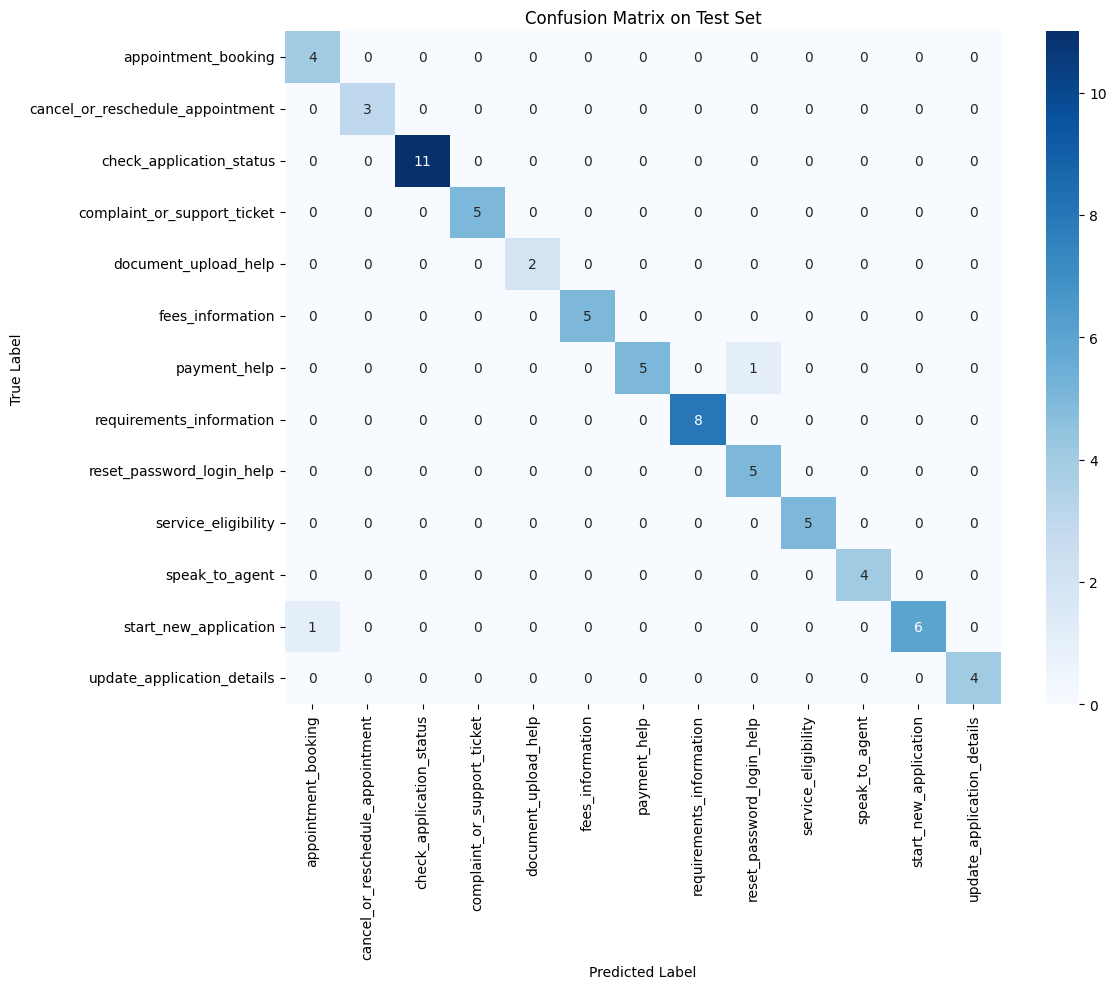


--- F1 Score per Language on Test Set ---
Language: rw, F1 Score: 0.9529
Language: en, F1 Score: 1.0000
Language: mixed, F1 Score: 1.0000
----------------------------------------


In [24]:
# Load the PEFT config for the saved adapter
peft_config = PeftConfig.from_pretrained("./final_lora_adapter")

# Load the base model and then the PEFT adapter on top
loaded_model = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=len(le.classes_),
    id2label=id2label,
    label2id=label2id
)
loaded_model = PeftModel.from_pretrained(loaded_model, "./final_lora_adapter")

loaded_model.eval()

prediction_args = TrainingArguments(
    output_dir="./prediction_output",
    per_device_eval_batch_size=16,
    report_to="none"
)

predictions_output = Trainer(
    model=loaded_model,
    args=prediction_args,
    data_collator=data_collator,
    processing_class=tokenizer,
).predict(tokenized_final["test"])

predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Confusion Matrix on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Evaluate F1 Score per Language
print("\n--- F1 Score per Language on Test Set ---")
unique_languages = test_df['language'].unique()

for lang in unique_languages:
    lang_indices = test_df[test_df['language'] == lang].index.tolist()

    # Get true labels and predictions for this specific language
    lang_true_labels = true_labels[lang_indices]
    lang_predictions = predictions[lang_indices]

    # Calculate F1 score (macro average due to potential class imbalance within language subsets)
    f1 = f1_score(lang_true_labels, lang_predictions, average='macro')
    print(f"Language: {lang}, F1 Score: {f1:.4f}")

print("----------------------------------------")
